## Feature Engineering

### Dimentionality Reduction

##### In this notebook we try to find unnecessary features and remove them from data, so the model can train easier and generalize better .

##### So far we have cleaned our data and searched for best possible hyper-parameters. Results are as below:

* Result don't change if we apply standard scaler on all features (OneHotEncoded categories and continuous) or only on continous features
* **RandomForestRegressor** works better than XGBRegressor with this dataset
* Best hyper-parameters: `n_estimators`=150, `max_depth`=None, `min_samples_leaf`=2, `max_features`=0.5
* Model produces better result when DV is not transformed. So we keep the original target values.
* Best results so far: `MAE`: 1.20551, `R^2`: 0.81978
<br><br><br>


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## I. Loading Data and environment setup

In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [0]:
# loading libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt
import os
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
# setting paths
# data_dir = os.path.abspath('./_data')
data_dir = os.path.abspath('/content/drive/My Drive/Projects/YapAiTek_Challenge/_data')
chp_dir = os.path.join(data_dir, 'checkpoint')
train_data_fp = os.path.join(data_dir, 'train_clean_msc.csv')
test_data_fp = os.path.join(data_dir, 'test_clean_msc.csv')
data_fp = os.path.join(data_dir, 'data_clean_msc.csv')
os.listdir(data_dir)

['data.csv',
 'test.csv',
 'data_no_missing.csv',
 'train_clean.csv',
 'test_clean.csv',
 'data_clean.csv',
 'train_clean_msc.csv',
 'test_clean_msc.csv',
 'data_clean_msc.csv',
 '(old)to_keep_columns_stage1.npy',
 '.ipynb_checkpoints',
 '(old)to_keep_columns_stage2.npy',
 'to_keep_columns_stage1.npy',
 'to_keep_columns_stage2.npy',
 'to_keep_columns_stage3.npy',
 'checkpoint']

In [6]:
data = pd.read_csv(data_fp)
print(data.shape)
data.head()

(770821, 94)


,ch_type,length,first_or_rerun,episodes_in_season,is_movie,overlaped_with_game,temperature,Week,Day,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,running_time,episode_name_na,temperature_na,station_ARTV+,station_Canal D+,station_Canal Vie+,station_Evasion+,station_Historia+,station_LCN+,station_MAX+,station_Meteomedia+,"station_MusiquePlus+ (retired Aug 25, 2019)",station_PYC Online Stream Fr CBC-8+,station_PYC Online Stream Fr CBC-9+,station_RDI+,station_RDS+,station_RDS2+,station_SRC Total,station_Series++,station_TQ Total,station_TV5+,station_TVA Total,station_Teletoon Fr.+,...,genre_Long-form Documentary,genre_Music Video Clips,genre_Music Video Programs,genre_Music and Dance other than Music Video Programs or Clips,genre_News,genre_Ongoing Comedy Series (Sitcoms),genre_Ongoing Dramatic Series,genre_Other Drama,genre_Professional Sports,"genre_Programs of Comedy Sketches, Improvision, Unscripted Works",genre_Reality Programs,genre_Religion,genre_Reporting and Actualities,"genre_Specials, Mini-Series or Made-for-TV Feature Films",genre_Theatre Feature Films Aired on TV,genre_Unknown,genre_Variety,Year_2016,Year_2017,Year_2018,Year_2019,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Dayofweek_0,Dayofweek_1,Dayofweek_2,Dayofweek_3,Dayofweek_4,Dayofweek_5,Dayofweek_6
0,0,0.086957,0,1,0,0,0.766733,0.666667,0.933333,0.660274,0,0,0,0,0,0,0.0,0.083391,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,0,0.021739,0,1,0,0,0.746293,0.666667,0.933333,0.660274,0,0,0,0,0,0,0.0,0.020848,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,0,0.021739,0,1,0,0,0.746293,0.666667,0.933333,0.660274,0,0,0,0,0,0,0.0,0.020848,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,0,0.043478,0,1,0,0,0.730261,0.666667,0.933333,0.660274,0,0,0,0,0,0,0.0,0.041696,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,0,0.021739,0,1,0,0,0.732265,0.666667,0.933333,0.660274,0,0,0,0,0,0,0.0,0.020848,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [7]:
# load the training set and shuffle it
train_set = pd.read_csv(train_data_fp)
y_true = train_set.market_share
train_set = train_set.sample(frac=1)
n_train = len(train_set)
print(f'Training samples: {n_train}')
train_set.head(1)

Training samples: 616656


,ch_type,length,first_or_rerun,episodes_in_season,is_movie,overlaped_with_game,temperature,Week,Day,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,running_time,episode_name_na,temperature_na,station_ARTV+,station_Canal D+,station_Canal Vie+,station_Evasion+,station_Historia+,station_LCN+,station_MAX+,station_Meteomedia+,"station_MusiquePlus+ (retired Aug 25, 2019)",station_PYC Online Stream Fr CBC-8+,station_PYC Online Stream Fr CBC-9+,station_RDI+,station_RDS+,station_RDS2+,station_SRC Total,station_Series++,station_TQ Total,station_TV5+,station_TVA Total,station_Teletoon Fr.+,...,genre_Music Video Programs,genre_Music and Dance other than Music Video Programs or Clips,genre_News,genre_Ongoing Comedy Series (Sitcoms),genre_Ongoing Dramatic Series,genre_Other Drama,genre_Professional Sports,"genre_Programs of Comedy Sketches, Improvision, Unscripted Works",genre_Reality Programs,genre_Religion,genre_Reporting and Actualities,"genre_Specials, Mini-Series or Made-for-TV Feature Films",genre_Theatre Feature Films Aired on TV,genre_Unknown,genre_Variety,Year_2016,Year_2017,Year_2018,Year_2019,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Dayofweek_0,Dayofweek_1,Dayofweek_2,Dayofweek_3,Dayofweek_4,Dayofweek_5,Dayofweek_6,market_share,market_share_transformed
183831,1,0.108696,0,1,0,0,0.628724,0.392157,0.7,0.386301,0,0,0,0,0,0,0.243813,0.104239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.2,-0.017927


In [0]:
# cut the dependant variable(s) form training set
# target = train_set.loc[:, 'market_share_transformed']
target_src = train_set.loc[:, 'market_share']
# targets_joint = train_set.loc[:, ['market_share_transformed', 'market_share']]

train_set.drop(columns=['market_share', 'market_share_transformed'], inplace=True)

In [0]:
# constant variables for later use
cv = 5    # number of folds for cross-validation
rs = 1    # random-state number
sample_size_large = 300000
sample_size_small = 35000

## II. Defining few helper functions

In [0]:
def get_rf_model(n_estimators=150, max_depth=None, min_samples_leaf=2, max_features=0.5, random_state=rs):
    rf = RandomForestRegressor(n_estimators=n_estimators,
                               max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features,
                               oob_score=True,
                               n_jobs=-1,
                               random_state=random_state)
    return rf

In [0]:
def evaluate(actual, prediction):
    return {'MAE': round(mean_absolute_error(actual, prediction), 5),
            'MSE': round(mean_squared_error(actual, prediction), 5),
            'R^2': round(r2_score(actual, prediction), 5)}

In [0]:
def get_oob_score(X_train, y_train):
    rf = RandomForestRegressor(n_estimators=30, min_samples_leaf=2, max_features=0.5, oob_score=True, n_jobs=-1, random_state=rs)
    rf.fit(X_train, y_train)
    score = rf.oob_score_
    del rf
    return round(score, 5)

In [13]:
get_oob_score(train_set.iloc[:sample_size_small], target_src.iloc[:sample_size_small])

0.74669

In [0]:
def get_sample_df(X_train, y_train, n_samples=20000):
    df = pd.concat(objs=[X_train, y_train], axis=1)
    x = df.sample(n=n_samples, axis=0)
    del df
    return x.iloc[:, :-1], x.iloc[:, -1]

In [0]:
def plot_feature_importance(fi, labels, n_features=None, figsize=(14, 8)):
    nf = n_features if n_features is not None else len(fi)
    
    fi = sorted(zip(fi, labels), reverse=True)[:nf]
    d = d = {k: v for v, k in fi}
    plt.figure(figsize=figsize)
    plt.bar(range(len(d)), list(d.values()), align='center')
    plt.xticks(range(len(d)), list(d.keys()), rotation='vertical')
    plt.show()
    del d

In [0]:
def full_eval(rf, X_train, y_train, X_test, y_test):
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    res = evaluate(y_test, preds)
    res['oob_score'] = round(rf.oob_score_, 5)
    return res
    

## III. Create sample train and test sets for later analysis

In [17]:
X_train, y_train = get_sample_df(train_set, target_src, n_samples=sample_size_large)
X_train.shape, y_train.shape

((300000, 94), (300000,))

In [18]:
X_test, y_test = get_sample_df(train_set, target_src, n_samples=sample_size_small)
X_test.shape, y_test.shape

((35000, 94), (35000,))

## 1. Get the most important features using RandomForest estimator

In [19]:
%%time

rf = get_rf_model()
print(full_eval(rf, X_train, y_train, X_test, y_test))

{'MAE': 1.02523, 'MSE': 3.41497, 'R^2': 0.86645, 'oob_score': 0.80308}
CPU times: user 10min 54s, sys: 502 ms, total: 10min 55s
Wall time: 2min 57s


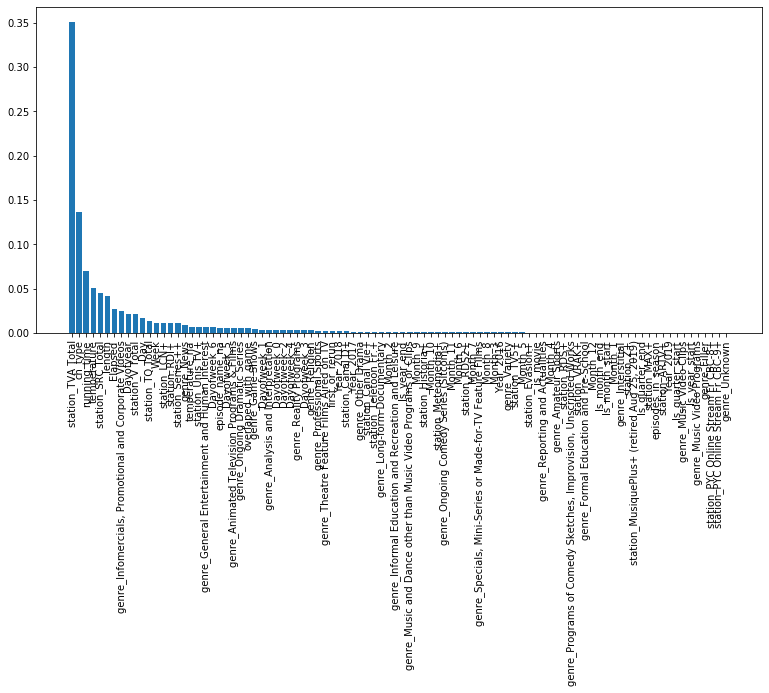

In [20]:
plot_feature_importance(rf.feature_importances_, X_train.columns, figsize=(13, 6))

In [0]:
fi = sorted(zip(rf.feature_importances_, X_train.columns), reverse=True)
to_keep = np.asarray([k for v, k in fi if v > 0.0013])
to_keep = to_keep[:50] if len(to_keep) > 50 else to_keep
print(len(to_keep))

44


In [0]:
to_keep

array(['station_TVA Total', 'ch_type', 'running_time', 'temperature',
       'station_SRC Total', 'length', 'Elapsed',
       'genre_Infomercials, Promotional and Corporate Videos',
       'Dayofyear', 'station_V Total', 'Day', 'station_TQ Total', 'Week',
       'station_LCN+', 'station_Series++', 'genre_News', 'station_RDI+',
       'station_Unis TV+',
       'genre_General Entertainment and Human Interest', 'temperature_na',
       'Dayofweek_6', 'episode_name_na', 'genre_Ongoing Dramatic Series',
       'genre_Animated Television Programs & Films', 'Dayofweek_5',
       'overlaped_with_game', 'genre_Game Shows', 'Dayofweek_1',
       'genre_Religion', 'Dayofweek_0', 'Dayofweek_4',
       'genre_Analysis and Interpretation', 'Dayofweek_3',
       'genre_Reality Programs', 'Dayofweek_2', 'first_or_rerun',
       'genre_Professional Sports',
       'genre_Theatre Feature Films Aired on TV', 'station_Canal D+',
       'Year_2018', 'genre_Other Drama', 'Year_2017',
       'station_Canal 

In [0]:
%%time

rf2 = get_rf_model()
rf2.fit(X_train[to_keep], y_train)

CPU times: user 6min 24s, sys: 1.76 s, total: 6min 26s
Wall time: 3min 23s


In [0]:
preds_reduced = rf2.predict(X_test[to_keep])
print('oob_score: %.5f' % rf2.oob_score_)
evaluate(y_test, preds_reduced)

oob_score: 0.79130


{'MAE': 1.07021, 'MSE': 3.25003, 'R^2': 0.85873}

In [0]:
# save extracted columns name to diske for later use
np.save(data_dir + '/to_keep_columns_stage1.npy', to_keep)

#### Section Summary:
**Since our model's performance only dropped slightly, keeping 50 most important features is good enough to continue.**

## 2. Hierarical Clustering Analysis (Pairwise Correlations)

In [0]:
to_keep = np.load(data_dir + '/to_keep_columns_stage1.npy')
to_keep.shape

(44,)

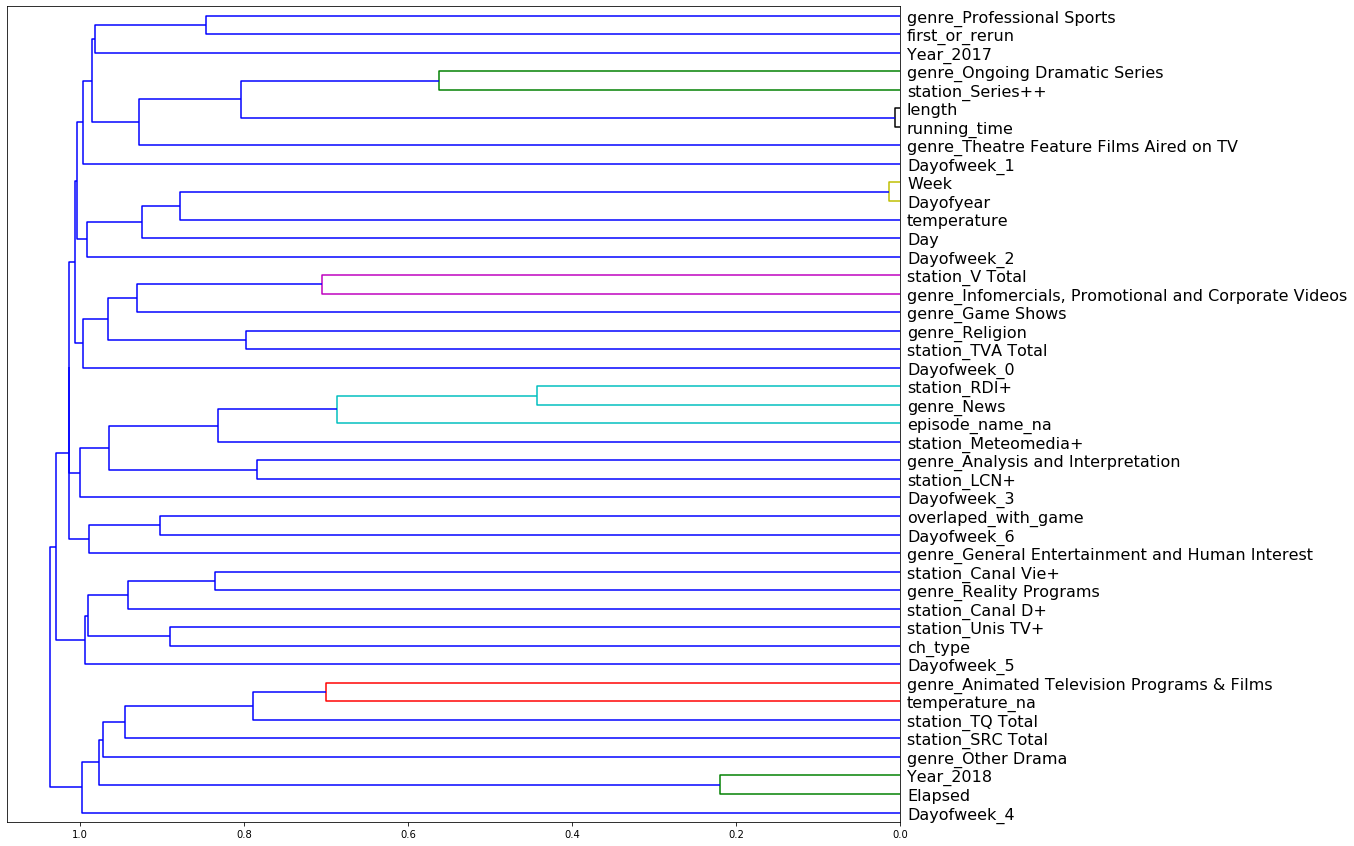

In [0]:
corr = np.round(stats.spearmanr(X_train[to_keep]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
Z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 15))
dendrogram = hc.dendrogram(Z, labels=X_train[to_keep].columns, orientation='left', leaf_font_size=16)
plt.show()

In [0]:
%%time
# evaluating model's performance with extracted columns -- (for reference only)
full_eval(get_rf_model(), X_train[to_keep], y_train, X_test[to_keep], y_test)

CPU times: user 7min 55s, sys: 1.36 s, total: 7min 56s
Wall time: 4min 9s


{'MAE': 1.07267, 'MSE': 3.60339, 'R^2': 0.84976, 'oob_score': 0.79246}

In [0]:
# removing 'length' feature
to_keep_new = to_keep[to_keep!= 'length']

In [0]:
%%time
# re-evaluating model's performance after dropping 'length' feature
full_eval(get_rf_model(), X_train[to_keep_new], y_train, X_test[to_keep_new], y_test)

CPU times: user 7min 15s, sys: 876 ms, total: 7min 16s
Wall time: 3min 49s


{'MAE': 1.07558, 'MSE': 3.60496, 'R^2': 0.84969, 'oob_score': 0.79273}

In [0]:
np.save(data_dir + '/to_keep_columns_stage2.npy', to_keep_new)

#### Section Summary:
**Based on above dendrogram plot, the only two related features are _running_time_ and _length_ and we tested that removing _length_ feature didn't drop our model's performance.**

## 3. Drop `Year_*` Features

**The training set keeps samples from year 2016 to early 2019 but test set samples are from year 2019. So, keeping year related features like `Year_2016` don't help our model to learn.**

In [0]:
to_keep = np.load(data_dir + '/to_keep_columns_stage2.npy')
to_keep.shape

(43,)

In [0]:
col_year = [col for col in to_keep if col.startswith('Year')]
col_year

['Year_2018', 'Year_2017']

In [0]:
%%time

print(full_eval(get_rf_model(),
          X_train.drop(columns=col_year),
          y_train,
          X_test.drop(columns=col_year),
          y_test))

{'MAE': 1.07677, 'MSE': 3.42147, 'R^2': 0.85688, 'oob_score': 0.78963}
CPU times: user 6min 57s, sys: 2.37 s, total: 7min
Wall time: 3min 41s


In [0]:
print(len(to_keep))
to_keep = [col for col in to_keep if col not in col_year]
print(len(to_keep))

43
41


In [0]:
np.save(data_dir + '/to_keep_columns_stage3.npy', to_keep)

## 4. Less important features and sparse features Grouping

In [0]:
# Loading 'to_keep' features list
to_keep = np.load(data_dir + '/to_keep_columns_stage3.npy')
to_keep.shape

(41,)

In [0]:
X_train = X_train[to_keep]
X_test = X_test[to_keep]

data = data[to_keep]    # only keeping extracted features in main dataset and dropping the rest

In [0]:
%%time

rf = get_rf_model()
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
print('oob_score: %.5f' % rf.oob_score_)
print(evaluate(y_test, preds))

oob_score: 0.79400
{'MAE': 1.07497, 'MSE': 3.35245, 'R^2': 0.85913}
CPU times: user 6min 6s, sys: 629 ms, total: 6min 7s
Wall time: 3min 12s


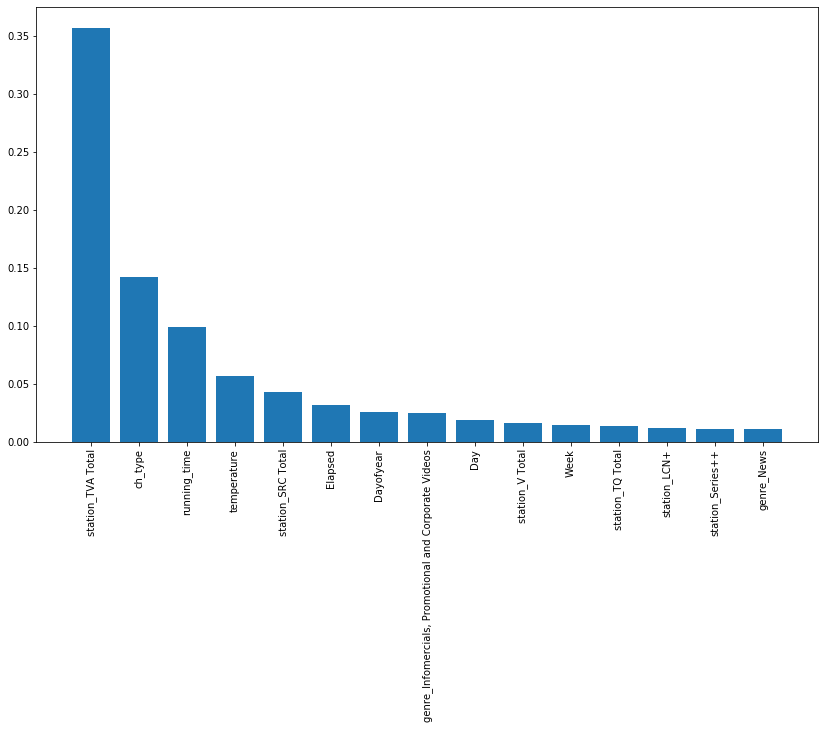

In [0]:
plot_feature_importance(rf.feature_importances_, X_train.columns, n_features=15)

In [0]:
to_keep

array(['station_TVA Total', 'ch_type', 'running_time', 'temperature',
       'station_SRC Total', 'Elapsed',
       'genre_Infomercials, Promotional and Corporate Videos',
       'Dayofyear', 'station_V Total', 'Day', 'station_TQ Total', 'Week',
       'station_LCN+', 'station_Series++', 'genre_News', 'station_RDI+',
       'station_Unis TV+',
       'genre_General Entertainment and Human Interest', 'temperature_na',
       'Dayofweek_6', 'episode_name_na', 'genre_Ongoing Dramatic Series',
       'genre_Animated Television Programs & Films', 'Dayofweek_5',
       'overlaped_with_game', 'genre_Game Shows', 'Dayofweek_1',
       'genre_Religion', 'Dayofweek_0', 'Dayofweek_4',
       'genre_Analysis and Interpretation', 'Dayofweek_3',
       'genre_Reality Programs', 'Dayofweek_2', 'first_or_rerun',
       'genre_Professional Sports',
       'genre_Theatre Feature Films Aired on TV', 'station_Canal D+',
       'genre_Other Drama', 'station_Canal Vie+', 'station_Meteomedia+'],
      dtype=

**It looks like lots of features in our `to_keep` list are `station`, `genre`, `Dayofweek` and `Month` related**

In [0]:
col_stations = np.asarray([col for col in to_keep if col.startswith('station')])
col_genres = np.asarray([col for col in to_keep if col.startswith('genre')])
col_weekday = np.asarray([col for col in to_keep if col.startswith('Dayofweek')])
# col_months = np.asarray([col for col in to_keep if col.startswith('Month')])


print(f'Stations: {len(col_stations)}')
print(f'Genres: {len(col_genres)}')
print(f'Days of Week: {len(col_weekday)}')
# print(f'Months: {len(col_months)}')

Stations: 11
Genres: 12
Days of Week: 7


### - `Dayofweek_*` features

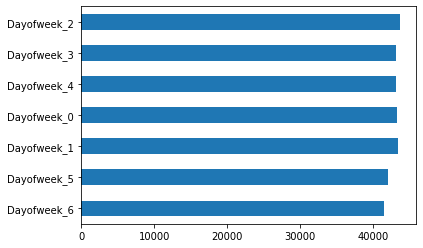

In [0]:
X_train[col_weekday].sum().plot(kind='barh')

In [0]:
X_train[col_weekday].var()

Dayofweek_6    0.119161
Dayofweek_5    0.120532
Dayofweek_1    0.123765
Dayofweek_0    0.123369
Dayofweek_4    0.122941
Dayofweek_3    0.122956
Dayofweek_2    0.124380
dtype: float64

**Amount of variation in different days of the week are roughly equal, so we keep the first 3 more important days and combine the rest.**

In [0]:
col_weekday_keep = col_weekday[:3]
col_weekday_comb = col_weekday[3:]
col_weekday_keep, col_weekday_comb

(array(['Dayofweek_6', 'Dayofweek_5', 'Dayofweek_1'], dtype='<U11'),
 array(['Dayofweek_0', 'Dayofweek_4', 'Dayofweek_3', 'Dayofweek_2'],
       dtype='<U11'))

In [0]:
X_train.shape, X_test.shape

((300000, 41), (35000, 41))

In [0]:
X_train_weekday = X_train.copy()
X_test_weekday = X_test.copy()

In [0]:
def combine_weekday(row, weekdays):
    if row[weekdays].sum() >= 1:
        return 1
    return 0

In [0]:
X_train_weekday['Dayofweek_other'] = X_train_weekday.apply(lambda x: combine_weekday(x, col_weekday_comb), axis=1)
X_test_weekday['Dayofweek_other'] = X_test_weekday.apply(lambda x: combine_weekday(x, col_weekday_comb), axis=1)

In [0]:
X_train_weekday.drop(columns=col_weekday_comb, inplace=True)
X_test_weekday.drop(columns=col_weekday_comb, inplace=True)

X_train_weekday.shape, X_test_weekday.shape

((300000, 38), (35000, 38))

In [0]:
%%time

rf = get_rf_model()
rf.fit(X_train_weekday, y_train)
preds = rf.predict(X_test_weekday)
print('oob_score: %.5f' % rf.oob_score_)
print(evaluate(y_test, preds))

oob_score: 0.78900
{'MAE': 1.08099, 'MSE': 3.41523, 'R^2': 0.85649}
CPU times: user 5min 42s, sys: 994 ms, total: 5min 43s
Wall time: 2min 59s


#### -- Applying this section discoveries to main dataset
We Keep 3 more important `Dayofweek‍‍‍‍‍_*` features and combine the rest in one column

In [0]:
%%time

data['Dayofweek_other'] = data.apply(lambda x: combine_weekday(x, col_weekday_comb), axis=1)
data.drop(columns=col_weekday_comb, inplace=True)
print(data.shape)

(770821, 38)
CPU times: user 7min 16s, sys: 1.18 s, total: 7min 17s
Wall time: 7min 18s


### - `genre_*` features

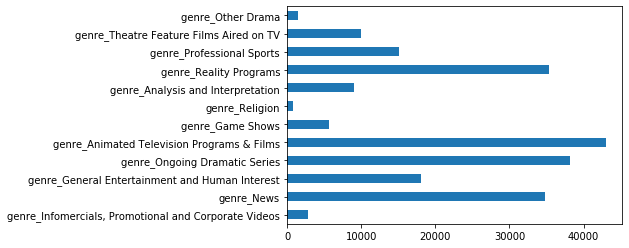

In [0]:
X_train[col_genres].sum().plot.barh()
plt.show()

In [0]:
X_train[col_genres].var()

genre_Infomercials, Promotional and Corporate Videos    0.009475
genre_News                                              0.102611
genre_General Entertainment and Human Interest          0.056784
genre_Ongoing Dramatic Series                           0.111050
genre_Animated Television Programs & Films              0.122842
genre_Game Shows                                        0.018652
genre_Religion                                          0.002809
genre_Analysis and Interpretation                       0.029041
genre_Reality Programs                                  0.103926
genre_Professional Sports                               0.047776
genre_Theatre Feature Films Aired on TV                 0.032347
genre_Other Drama                                       0.005001
dtype: float64

In [0]:
# genres with the lowest variance
genres_comb = ['genre_Infomercials, Promotional and Corporate Videos', 'genre_Religion', 'genre_Other Drama']

In [0]:
def combine_genres(row, genres):
    if row[genres].sum() >= 1:
        return 1
    return 0

In [0]:
X_train_genre = X_train_weekday.copy()
X_test_genre = X_test_weekday.copy()

X_train_genre.shape, X_test_genre.shape

((300000, 38), (35000, 38))

In [0]:
X_train_genre['genre_comb'] = X_train_genre.apply(lambda x: combine_genres(x, genres_comb), axis=1)
X_test_genre['genre_comb'] = X_test_genre.apply(lambda x: combine_genres(x, genres_comb), axis=1)

X_train_genre.drop(columns=genres_comb, inplace=True)
X_test_genre.drop(columns=genres_comb, inplace=True)

In [0]:
X_train_genre.shape, X_test_genre.shape

((300000, 36), (35000, 36))

In [0]:
%%time

rf = get_rf_model()
print(full_eval(rf, X_train_genre, y_train, X_test_genre, y_test))

{'MAE': 1.08069, 'MSE': 3.41265, 'R^2': 0.8566, 'oob_score': 0.78788}
CPU times: user 5min 45s, sys: 678 ms, total: 5min 46s
Wall time: 3min 1s


In [0]:
print('Number of genres_* columns: {}'.format(len([col for col in X_train_genre.columns if col.startswith('genre')])))

Number of genres_* columns: 10


#### -- Applying this section discoveries to main dataset
We combine 3 of `genre_*` features with the lowest variance into one column.

In [0]:
%%time

data['genre_comb'] = data.apply(lambda x: combine_genres(x, genres_comb), axis=1)
data.drop(columns=genres_comb, inplace=True)
print(data.shape)

(770821, 36)
CPU times: user 8min 48s, sys: 463 ms, total: 8min 49s
Wall time: 8min 52s


### - `station_*` features

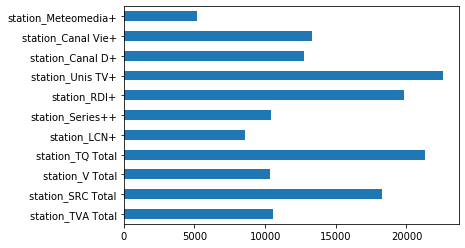

In [0]:
X_train[col_stations].sum().plot(kind='barh')
plt.show()

In [0]:
# col_stations_keep = col_stations[:6]
col_stations_comb = col_stations[-3:]
col_stations_comb

array(['station_Canal D+', 'station_Canal Vie+', 'station_Meteomedia+'],
      dtype='<U19')

In [0]:
X_train_station = X_train_genre.copy()
X_test_station = X_test_genre.copy()

X_train_station.shape, X_test_station.shape

((300000, 36), (35000, 36))

In [0]:
def combine_stations(row, stations):
    if row[stations].sum() >= 1:
        return 1
    return 0

In [0]:
%%time

X_train_station['station_comb'] = X_train_station.apply(lambda x: combine_stations(x, col_stations_comb), axis=1)
X_test_station['station_comb'] = X_test_station.apply(lambda x: combine_stations(x, col_stations_comb), axis=1)

X_train_station.drop(columns=col_stations_comb, inplace=True)
X_test_station.drop(columns=col_stations_comb, inplace=True)

print(X_train_station.shape, X_test_station.shape)

(300000, 34) (35000, 34)
CPU times: user 3min 11s, sys: 458 ms, total: 3min 11s
Wall time: 3min 12s


In [0]:
%%time

rf = get_rf_model()
print(full_eval(rf, X_train_station, y_train, X_test_station, y_test))

{'MAE': 1.08314, 'MSE': 3.42366, 'R^2': 0.85613, 'oob_score': 0.78735}
CPU times: user 5min 29s, sys: 579 ms, total: 5min 30s
Wall time: 2min 53s


In [0]:
print('Number of station_* columns: {}'.format(len([col for col in X_train_station.columns if col.startswith('station')])))

Number of station_* columns: 9


#### -- Applying this section discoveries to main dataset
We combine the 3 less important `station_*` features into one column.

In [0]:
%%time

data['station_comb'] = data.apply(lambda x: combine_stations(x, col_stations_comb), axis=1)
data.drop(columns=col_stations_comb, inplace=True)
print(data.shape)

(770821, 34)
CPU times: user 7min 18s, sys: 1.2 s, total: 7min 20s
Wall time: 7min 21s


## Checkpoink: Save/Load dataframes

### Save a copy of dataframes to disk 

In [0]:
X_train = X_train_station.copy()
X_test = X_test_station.copy()

# del X_train_weekday, X_train_genre, X_train_station
# del X_test_weekday, X_test_genre, X_test_station

In [0]:
data.to_csv(data_dir+'/checkpoint/data_34ft.csv', index=False)       # Save as csv file
X_train.to_csv(data_dir+'/checkpoint/X_train_34ft.csv', index=False) # Save as csv file
y_train.to_pickle(data_dir+'/checkpoint/y_train_34ft.pkl')           # Save as pickle file
X_test.to_csv(data_dir+'/checkpoint/X_test_34ft.csv', index=False)   # Save as csv file
y_test.to_pickle(data_dir+'/checkpoint/y_test_34ft.pkl')             # Save as pickle file

### Loading the saved dataframes

In [0]:
data = pd.read_csv(chp_dir+'/data_34ft.csv')
X_train = pd.read_csv(chp_dir+'/X_train_34ft.csv')
y_train = pd.read_pickle(chp_dir+'/y_train_34ft.pkl')
X_test = pd.read_csv(chp_dir+'/X_test_34ft.csv')
y_test = pd.read_pickle(chp_dir+'/y_test_34ft.pkl')

In [22]:
print('data: ', data.shape)
print('Train X & y: ', X_train.shape, y_train.shape)
print('Test X & y: ', X_test.shape, y_test.shape)

data:  (770821, 34)
Train X & y:  (300000, 34) (300000,)
Test X & y:  (35000, 34) (35000,)


## 5. Univariate feature selection

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [0]:
kbest = SelectKBest(score_func=f_regression, k=X_train.shape[1])
kbfit = kbest.fit(X_train, y_train)

In [25]:
# Get the scores and print the 5 worst features
scores = sorted(zip(kbfit.scores_, X_train.columns))
print('5 features with the lowest scores:')
print(scores[:5])

5 features with the lowest scores:
[(1.0456832796097926, 'Day'), (2.785378955443058, 'first_or_rerun'), (6.215140208000224, 'overlaped_with_game'), (8.95691221560909, 'Dayofyear'), (9.339744403787543, 'Week')]


Based on `f_regression` function's score, `Day` feature is the worst one. So we make a full evaluation without that feature.

In [26]:
%%time
print(full_eval(get_rf_model(),
                X_train.drop(columns=['Day']), 
                y_train, 
                X_test.drop(columns=['Day']), 
                y_test))

{'MAE': 1.08594, 'MSE': 3.42192, 'R^2': 0.85621, 'oob_score': 0.7883}
CPU times: user 5min 11s, sys: 1.43 s, total: 5min 12s
Wall time: 1min 28s


Since the model's performance didn't drop, we remove the `Day` feature from the dataframes.

In [0]:
X_train.drop(columns=['Day'], inplace=True)
X_test.drop(columns=['Day'], inplace=True)
data.drop(columns=['Day'], inplace=True)

## 6. SparsePCA

In [0]:
from sklearn.decomposition import SparsePCA

In [34]:
%%time
spca30 = SparsePCA(n_components=30, n_jobs=-1, random_state=rs)
spca30.fit(X_train)

CPU times: user 30min 16s, sys: 23min 12s, total: 53min 28s
Wall time: 16min 33s


In [35]:
X_train_tmp = spca30.transform(X_train)
X_test_tmp = spca30.transform(X_test)

X_train_tmp.shape, X_test_tmp.shape

((300000, 30), (35000, 30))

In [36]:
%%time
print(full_eval(get_rf_model(), X_train_tmp, y_train, X_test_tmp, y_test))

{'MAE': 1.08704, 'MSE': 3.44362, 'R^2': 0.85529, 'oob_score': 0.78914}
CPU times: user 5min 37s, sys: 782 ms, total: 5min 37s
Wall time: 1min 34s


In [0]:
data_tmp = spca30.transform(data)

## Checkpoink: Save/Load ndarrays

### Save a copy of transformed data-sets to disk 

In [0]:
np.save(chp_dir+'/data_30ft.npy', data_tmp)
np.save(chp_dir+'/X_train_30ft.npy', X_train_tmp)
np.save(chp_dir+'/X_test_30ft.npy', X_test_tmp)

### Loading the saved ndarrays

In [66]:
data = np.load(chp_dir+'/data_30ft.npy')
data.shape

(770821, 30)

## Splitting the final transformed version of data and save files to disk

In [69]:
train = data[:n_train]
test = data[n_train:]

train.shape, test.shape

((616656, 30), (154165, 30))

In [0]:
# FINAL VERSION
np.save(data_dir+'/X_train_final.npy', train)
np.save(data_dir+'/y_train_final.npy', y_true.values)
np.save(data_dir+'/X_test_final.npy', test)